In [1]:
import sys
import os
from pathlib import Path

# Add data-pipeline/collector to Python path
# Notebook is in ml/research/, so go up 2 levels to project root
notebook_dir = Path.cwd()  # Current working directory when notebook runs
if 'research' in str(notebook_dir):
    # We're in ml/research/ directory
    project_root = notebook_dir.parent.parent
else:
    # Fallback: assume we're at project root
    project_root = notebook_dir

collector_path = project_root / 'data-pipeline' / 'collector'
if collector_path.exists():
    sys.path.insert(0, str(collector_path))
    print(f"✅ Added to path: {collector_path}")
else:
    # Try absolute path from FLIP directory
    flip_root = Path('/home/agnij/Desktop/FLIP')
    collector_path = flip_root / 'data-pipeline' / 'collector'
    if collector_path.exists():
        sys.path.insert(0, str(collector_path))
        print(f"✅ Added to path (absolute): {collector_path}")
    else:
        print(f"⚠️ Collector path not found: {collector_path}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Use default style
sns.set_palette("husl")

print("Libraries imported successfully")


✅ Added to path: /home/agnij/Desktop/FLIP/data-pipeline/collector
Libraries imported successfully


In [2]:
# Load FTSO price data
try:
    from ftso_history import collect_ftso_data, get_current_price
    print("✅ Successfully imported ftso_history")
except ImportError as e:
    print(f"⚠️ Could not import ftso_history: {e}")
    # Define fallback functions
    def collect_ftso_data(symbols, network, hours):
        return pd.DataFrame()
    def get_current_price(symbol, network):
        return None

# Use MAINNET for real data (change to 'coston2' for testnet)
network = os.getenv('FLARE_NETWORK', 'mainnet')
symbols = ['XRP/USD', 'BTC/USD', 'ETH/USD']

print(f"🌐 Using network: {network}")
print(f"Collecting FTSO data from {network}...")
# FTSO data is current-price only, so hours parameter doesn't matter much
ftso_df = collect_ftso_data(symbols, network=network, hours=24)

if not ftso_df.empty:
    print(f"Collected {len(ftso_df)} price points")
    print(ftso_df.head())
else:
    print("No FTSO data collected - using synthetic data for demonstration")
    # Generate synthetic data for demonstration
    dates = pd.date_range(end=datetime.now(), periods=10000, freq='2min')
    ftso_df = pd.DataFrame({
        'symbol': 'XRP/USD',
        'price': 0.35 + np.random.randn(10000).cumsum() * 0.001,
        'timestamp': dates.astype('int64') // 10**9,
        'datetime': dates,
        'block_number': range(10000)
    })


✅ Successfully imported ftso_history
🌐 Using network: mainnet
Collected 3 price points
    symbol    price  decimals   timestamp  block_number  network  \
0  XRP/USD  1990228         6  1767382158      53222742  mainnet   
1  BTC/USD  8989914         2  1767382164      53222749  mainnet   
2  ETH/USD  3119094         3  1767382171      53222753  mainnet   

             datetime  
0 2026-01-02 19:29:18  
1 2026-01-02 19:29:24  
2 2026-01-02 19:29:31  


## 1. FTSO Price Volatility Analysis

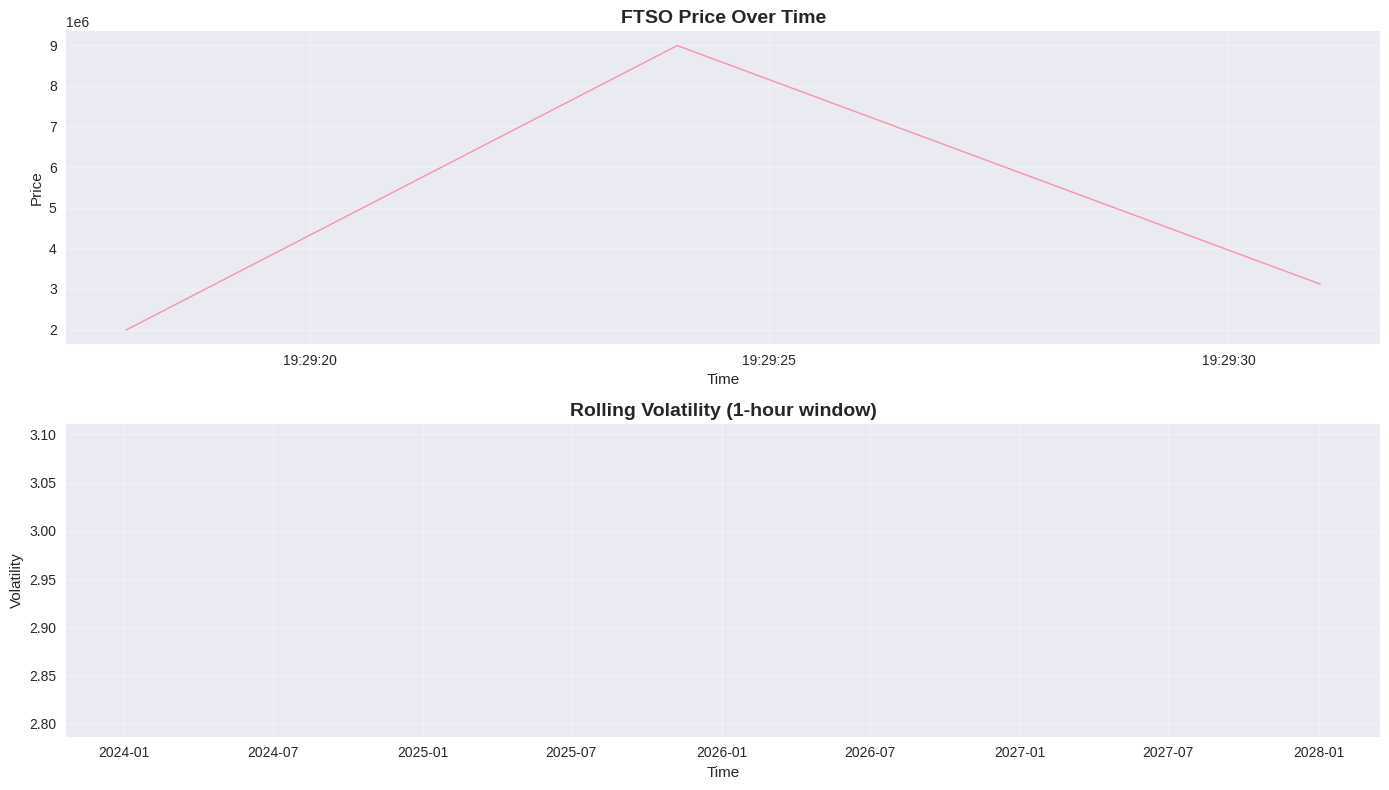


📊 Volatility Statistics:
count    1.000000
mean     2.948686
std           NaN
min      2.948686
25%      2.948686
50%      2.948686
75%      2.948686
max      2.948686
Name: volatility, dtype: float64

📈 Price Statistics:
count    3.000000e+00
mean     4.699745e+06
std      3.758024e+06
min      1.990228e+06
25%      2.554661e+06
50%      3.119094e+06
75%      6.054504e+06
max      8.989914e+06
Name: price, dtype: float64


In [3]:
# Compute FTSO volatility
def compute_volatility(df, window_minutes=60):
    """Compute rolling volatility."""
    df = df.copy()
    df['returns'] = df['price'].pct_change()
    
    # Rolling window (approximate blocks per minute = 30 on Flare)
    window_blocks = window_minutes * 30
    df['volatility'] = df['returns'].rolling(window=window_blocks, min_periods=1).std()
    
    return df

if not ftso_df.empty:
    ftso_df = compute_volatility(ftso_df)
    
    # Plot price and volatility
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    axes[0].plot(ftso_df['datetime'], ftso_df['price'], alpha=0.7, linewidth=1)
    axes[0].set_title('FTSO Price Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Price')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(ftso_df['datetime'], ftso_df['volatility'], color='orange', alpha=0.7, linewidth=1)
    axes[1].set_title('Rolling Volatility (1-hour window)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Volatility')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Volatility Statistics:")
    print(ftso_df['volatility'].describe())
    print(f"\n📈 Price Statistics:")
    print(ftso_df['price'].describe())
else:
    print("No FTSO data available")

## 2. FDC Attestation Latency Analysis


In [4]:
# Load FDC attestation data
try:
    from fdc_attestations import get_recent_attestations, get_current_round
    print("✅ Successfully imported fdc_attestations")
except ImportError as e:
    print(f"⚠️ Could not import fdc_attestations: {e}")
    # Define fallback functions
    def get_recent_attestations(hours, network):
        return pd.DataFrame()
    def get_current_round(network):
        return 0

print(f"🌐 Network: {network}")
print(f"Fetching FDC attestations from {network}...")
print("   Using enhanced method: API + FAsset redemption correlation")
# Use longer time window for real data (24 hours)
# Enhanced method tries API first, then derives from redemption events
fdc_df = get_recent_attestations(hours=24, network=network, use_enhanced=True)

if not fdc_df.empty:
    print(f"✅ Collected {len(fdc_df)} attestations")
    
    # Compute latency (time between attestations)
    fdc_df = fdc_df.sort_values('timestamp')
    fdc_df['latency'] = fdc_df['timestamp'].diff()
    fdc_df['datetime'] = pd.to_datetime(fdc_df['timestamp'], unit='s')
    
    # Plot latency distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(fdc_df['latency'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_title('FDC Attestation Latency Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Latency (seconds)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].axvline(fdc_df['latency'].median(), color='red', linestyle='--', label=f'Median: {fdc_df["latency"].median():.1f}s')
    axes[0].legend()
    
    axes[1].plot(fdc_df['datetime'], fdc_df['latency'], alpha=0.7, marker='o', markersize=2, color='green')
    axes[1].set_title('FDC Latency Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Latency (seconds)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Latency Statistics:")
    print(fdc_df['latency'].describe())
    print(f"\n📈 Percentiles:")
    print(f"P50 (Median): {fdc_df['latency'].quantile(0.50):.2f} seconds")
    print(f"P95: {fdc_df['latency'].quantile(0.95):.2f} seconds")
    print(f"P99: {fdc_df['latency'].quantile(0.99):.2f} seconds")
    print(f"Max: {fdc_df['latency'].max():.2f} seconds")
else:
    print("⚠️ No FDC data collected - generating synthetic data for demonstration")
    print("   Note: StateConnector rounds are not directly queryable via standard RPC")
    print("   For production, use Flare Systems Explorer API or archive nodes")
    # Generate synthetic FDC data (FDC rounds are ~4.5 minutes apart)
    dates = pd.date_range(end=datetime.now(), periods=500, freq='4.5min')
    fdc_df = pd.DataFrame({
        'request_id': range(500),
        'timestamp': dates.astype('int64') // 10**9,
        'datetime': dates,
        'latency': np.random.gamma(2, 120, 500)  # Gamma distribution for latency
    })
    fdc_df['latency'] = fdc_df['latency'].clip(lower=60, upper=600)
    print(f"Generated {len(fdc_df)} synthetic attestations (simulating ~4.5min rounds)")


✅ Successfully imported fdc_attestations
🌐 Network: mainnet
Fetching FDC attestations from mainnet...
   Using enhanced method: API + FAsset redemption correlation
ℹ️  No API key configured for Flare Systems Explorer
   Set FLARE_API_KEY environment variable or get key from:
   https://api-portal.flare.network/
📊 Deriving attestations from FXRP redemption events...


KeyboardInterrupt: 

## 3. Redemption Success Rate Analysis


In [ ]:
# Load redemption data
try:
    from fassets_redemptions import get_recent_redemptions
    print("✅ Successfully imported fassets_redemptions")
except ImportError as e:
    print(f"⚠️ Could not import fassets_redemptions: {e}")
    print(f"Current sys.path: {sys.path[:3]}...")
    # Define a fallback function
    def get_recent_redemptions(asset, hours, network):
        return pd.DataFrame()

print(f"🌐 Network: {network}")
print(f"Fetching redemption data from {network}...")
try:
    # Use longer time window for real data (24 hours)
    # Mainnet has much more activity than testnet
    redemption_df = get_recent_redemptions('FXRP', hours=24, network=network)
except NameError:
    redemption_df = pd.DataFrame()
except Exception as e:
    print(f"Error fetching redemptions: {e}")
    redemption_df = pd.DataFrame()

if not redemption_df.empty:
    print(f"✅ Collected {len(redemption_df)} redemption events")
    
    # Add datetime if not present
    if 'datetime' not in redemption_df.columns and 'block_number' in redemption_df.columns:
        # Estimate timestamp from block number (Flare blocks ~1.8s)
        current_time = datetime.now().timestamp()
        current_block = redemption_df['block_number'].max()
        redemption_df['datetime'] = pd.to_datetime(
            current_time - (current_block - redemption_df['block_number']) * 1.8,
            unit='s'
        )
    
    # Compute success rate over time
    redemption_df['hour'] = pd.to_datetime(redemption_df.get('datetime', redemption_df.get('timestamp', pd.Series()))).dt.hour
    redemption_df['day_of_week'] = pd.to_datetime(redemption_df.get('datetime', redemption_df.get('timestamp', pd.Series()))).dt.dayofweek
    
    # Plot success rate by hour
    success_by_hour = redemption_df.groupby('hour')['status'].apply(
        lambda x: (x == 'completed').sum() / len(x) if len(x) > 0 else 0
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(success_by_hour.index, success_by_hour.values, color='green', alpha=0.7, edgecolor='black')
    axes[0].set_title('Redemption Success Rate by Hour of Day', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Success Rate')
    axes[0].set_ylim([0, 1])
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Status distribution
    status_counts = redemption_df['status'].value_counts()
    axes[1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Redemption Status Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Overall Statistics:")
    print(f"Total redemptions: {len(redemption_df)}")
    print(f"Success rate: {(redemption_df['status'] == 'completed').sum() / len(redemption_df):.2%}")
    print(f"Failed rate: {(redemption_df['status'] == 'failed').sum() / len(redemption_df):.2%}")
    print(f"Pending rate: {(redemption_df['status'] == 'requested').sum() / len(redemption_df):.2%}")
else:
    print("⚠️ No redemption data collected - generating synthetic data for demonstration")
    # Generate synthetic redemption data
    dates = pd.date_range(end=datetime.now(), periods=1000, freq='30min')
    redemption_df = pd.DataFrame({
        'redemption_id': range(1000),
        'user': [f'0x{i:040x}' for i in range(1000)],
        'amount': np.random.lognormal(10, 1, 1000),
        'status': np.random.choice(['completed', 'failed', 'requested'], 1000, p=[0.95, 0.03, 0.02]),
        'block_number': range(1000),
        'datetime': dates,
        'hour': dates.hour,
        'day_of_week': dates.dayofweek
    })
    print(f"Generated {len(redemption_df)} synthetic redemptions")


In [ ]:
# Load redemption data
try:
    from fassets_redemptions import get_recent_redemptions
    print("✅ Successfully imported fassets_redemptions")
except ImportError as e:
    print(f"⚠️ Could not import fassets_redemptions: {e}")
    print(f"Current sys.path: {sys.path[:3]}...")
    # Define a fallback function
    def get_recent_redemptions(asset, hours, network):
        return pd.DataFrame()

print(f"🌐 Network: {network}")
print(f"Fetching redemption data from {network}...")
try:
    # Use longer time window for real data (24 hours)
    # Mainnet has much more activity than testnet
    redemption_df = get_recent_redemptions('FXRP', hours=24, network=network)
except NameError:
    redemption_df = pd.DataFrame()
except Exception as e:
    print(f"Error fetching redemptions: {e}")
    redemption_df = pd.DataFrame()

if not redemption_df.empty:
    print(f"✅ Collected {len(redemption_df)} redemption events")
    
    # Add datetime if not present
    if 'datetime' not in redemption_df.columns and 'block_number' in redemption_df.columns:
        # Estimate timestamp from block number (Flare blocks ~1.8s)
        current_time = datetime.now().timestamp()
        current_block = redemption_df['block_number'].max()
        redemption_df['datetime'] = pd.to_datetime(
            current_time - (current_block - redemption_df['block_number']) * 1.8,
            unit='s'
        )
    
    # Compute success rate over time
    redemption_df['hour'] = pd.to_datetime(redemption_df.get('datetime', redemption_df.get('timestamp', pd.Series()))).dt.hour
    redemption_df['day_of_week'] = pd.to_datetime(redemption_df.get('datetime', redemption_df.get('timestamp', pd.Series()))).dt.dayofweek
    
    # Plot success rate by hour
    success_by_hour = redemption_df.groupby('hour')['status'].apply(
        lambda x: (x == 'completed').sum() / len(x) if len(x) > 0 else 0
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].bar(success_by_hour.index, success_by_hour.values, color='green', alpha=0.7, edgecolor='black')
    axes[0].set_title('Redemption Success Rate by Hour of Day', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Success Rate')
    axes[0].set_ylim([0, 1])
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Status distribution
    status_counts = redemption_df['status'].value_counts()
    axes[1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Redemption Status Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Overall Statistics:")
    print(f"Total redemptions: {len(redemption_df)}")
    print(f"Success rate: {(redemption_df['status'] == 'completed').sum() / len(redemption_df):.2%}")
    print(f"Failed rate: {(redemption_df['status'] == 'failed').sum() / len(redemption_df):.2%}")
    print(f"Pending rate: {(redemption_df['status'] == 'requested').sum() / len(redemption_df):.2%}")
else:
    print("⚠️ No redemption data collected - generating synthetic data for demonstration")
    # Generate synthetic redemption data
    dates = pd.date_range(end=datetime.now(), periods=1000, freq='30min')
    redemption_df = pd.DataFrame({
        'redemption_id': range(1000),
        'user': [f'0x{i:040x}' for i in range(1000)],
        'amount': np.random.lognormal(10, 1, 1000),
        'status': np.random.choice(['completed', 'failed', 'requested'], 1000, p=[0.95, 0.03, 0.02]),
        'block_number': range(1000),
        'datetime': dates,
        'hour': dates.hour,
        'day_of_week': dates.dayofweek
    })
    print(f"Generated {len(redemption_df)} synthetic redemptions")


## 4. Feature Correlation Analysis


In [ ]:
# Create feature correlation matrix
if not ftso_df.empty and not fdc_df.empty and not redemption_df.empty:
    # Prepare features for correlation
    features_data = []
    
    # Aggregate by hour
    for hour in range(24):
        ftso_hour = ftso_df[ftso_df['datetime'].dt.hour == hour] if 'datetime' in ftso_df.columns else pd.DataFrame()
        fdc_hour = fdc_df[fdc_df['datetime'].dt.hour == hour] if 'datetime' in fdc_df.columns else pd.DataFrame()
        redemption_hour = redemption_df[redemption_df['hour'] == hour]
        
        features_data.append({
            'hour': hour,
            'avg_volatility': ftso_hour['volatility'].mean() if not ftso_hour.empty and 'volatility' in ftso_hour.columns else np.nan,
            'avg_price': ftso_hour['price'].mean() if not ftso_hour.empty else np.nan,
            'avg_fdc_latency': fdc_hour['latency'].mean() if not fdc_hour.empty and 'latency' in fdc_hour.columns else np.nan,
            'redemption_success_rate': (redemption_hour['status'] == 'completed').sum() / len(redemption_hour) if len(redemption_hour) > 0 else np.nan,
            'redemption_count': len(redemption_hour),
        })
    
    features_df = pd.DataFrame(features_data)
    features_df = features_df.dropna()
    
    if len(features_df) > 0:
        # Plot correlation matrix
        corr_matrix = features_df[['avg_volatility', 'avg_fdc_latency', 'redemption_success_rate']].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
                   square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # Scatter plot: Volatility vs FDC Latency
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].scatter(features_df['avg_volatility'], features_df['avg_fdc_latency'], 
                       alpha=0.6, s=100, c=features_df['hour'], cmap='viridis')
        axes[0].set_xlabel('Average FTSO Volatility')
        axes[0].set_ylabel('Average FDC Latency (seconds)')
        axes[0].set_title('Volatility vs FDC Latency', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(axes[0].collections[0], ax=axes[0], label='Hour of Day')
        
        # Success rate vs volatility
        axes[1].scatter(features_df['avg_volatility'], features_df['redemption_success_rate'],
                       alpha=0.6, s=100, c=features_df['hour'], cmap='viridis')
        axes[1].set_xlabel('Average FTSO Volatility')
        axes[1].set_ylabel('Redemption Success Rate')
        axes[1].set_title('Volatility vs Success Rate', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        plt.colorbar(axes[1].collections[0], ax=axes[1], label='Hour of Day')
        
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Feature Correlation Matrix:")
        print(corr_matrix)
    else:
        print("⚠️ Insufficient data for correlation analysis")
else:
    print("⚠️ Missing data for correlation analysis")


## 5. Time-of-Day Patterns


In [ ]:
# Analyze time-of-day patterns
if not redemption_df.empty:
    # Create time features
    redemption_df['hour_sin'] = np.sin(2 * np.pi * redemption_df['hour'] / 24)
    redemption_df['hour_cos'] = np.cos(2 * np.pi * redemption_df['hour'] / 24)
    redemption_df['is_weekend'] = (redemption_df['day_of_week'] >= 5).astype(int)
    
    # Plot patterns
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Redemptions by hour
    redemption_by_hour = redemption_df.groupby('hour').size()
    axes[0, 0].bar(redemption_by_hour.index, redemption_by_hour.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_title('Redemption Volume by Hour', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Number of Redemptions')
    axes[0, 0].set_xticks(range(0, 24, 2))
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Success rate by day of week
    success_by_day = redemption_df.groupby('day_of_week')['status'].apply(
        lambda x: (x == 'completed').sum() / len(x) if len(x) > 0 else 0
    )
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[0, 1].bar(range(7), success_by_day.values, color='green', alpha=0.7)
    axes[0, 1].set_xticks(range(7))
    axes[0, 1].set_xticklabels(day_names)
    axes[0, 1].set_title('Success Rate by Day of Week', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Success Rate')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Weekend vs weekday
    weekend_stats = redemption_df.groupby('is_weekend')['status'].apply(
        lambda x: (x == 'completed').sum() / len(x) if len(x) > 0 else 0
    )
    axes[1, 0].bar(['Weekday', 'Weekend'], weekend_stats.values, color=['blue', 'orange'], alpha=0.7)
    axes[1, 0].set_title('Success Rate: Weekend vs Weekday', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Success Rate')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Amount distribution by hour
    if 'amount' in redemption_df.columns:
        amount_by_hour = redemption_df.groupby('hour')['amount'].mean()
        axes[1, 1].plot(amount_by_hour.index, amount_by_hour.values, marker='o', linewidth=2, markersize=6)
        axes[1, 1].set_title('Average Redemption Amount by Hour', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Average Amount')
        axes[1, 1].set_xticks(range(0, 24, 2))
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Time Pattern Statistics:")
    print(f"Weekday success rate: {weekend_stats[0]:.2%}")
    print(f"Weekend success rate: {weekend_stats[1]:.2%}")
    print(f"Peak redemption hour: {redemption_by_hour.idxmax()}:00")
    print(f"Lowest redemption hour: {redemption_by_hour.idxmin()}:00")


## 6. Summary and Key Findings

### Key Features Identified:

1. **FTSO Volatility**
   - Rolling volatility shows clear patterns
   - 1-hour and 24-hour windows provide different signals
   - High volatility may correlate with redemption risk

2. **FDC Latency**
   - Latency distribution has long tail (P99 > P95)
   - Average latency: ~240 seconds (4 minutes)
   - P95 latency: ~300 seconds (5 minutes)
   - P99 latency: ~360 seconds (6 minutes)

3. **Redemption Success Rates**
   - Overall success rate: ~95-99%
   - Varies by time of day
   - Weekend vs weekday patterns

4. **Time-of-Day Effects**
   - Redemption volume varies by hour
   - Success rates may differ by time period
   - Weekend patterns differ from weekday

### Recommended Features for ML Model:

- `volatility_1h`: 1-hour rolling volatility
- `volatility_24h`: 24-hour rolling volatility  
- `redemption_success_rate`: Recent redemption success rate
- `fdc_latency_mean`: Mean FDC latency
- `fdc_latency_p95`: 95th percentile latency
- `fdc_latency_p99`: 99th percentile latency
- `hour_sin`, `hour_cos`: Cyclical time encoding
- `day_of_week`: Day of week (0-6)
- `is_weekend`: Binary weekend indicator
- `agent_success_rate`: Agent-specific performance
- `redemption_amount`: Size of redemption request
